# Introducción

La predicción temprana de accidentes cerebrovasculares es un problema crítico dentro del ámbito de la salud pública. Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular constituye la segunda causa de muerte a nivel mundial y representa aproximadamente el 11% del total de fallecimientos globales. La posibilidad de anticipar estos eventos a partir de información clínica y demográfica habilita herramientas de prevención e intervención temprana.

En este trabajo práctico se desarrolla un modelo de aprendizaje automático orientado a predecir la probabilidad de que un paciente sufra un accidente cerebrovascular, utilizando como insumo el Stroke Prediction Dataset publicado en Kaggle. El objetivo es explorar las variables disponibles, realizar el preprocesamiento necesario, comparar distintas alternativas de modelado y finalmente seleccionar un algoritmo que permita obtener un desempeño robusto y clínicamente útil.

Fuente del dataset:
Federico Soriano, Stroke Prediction Dataset, Kaggle (2021).
Disponible en: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, ConfusionMatrixDisplay, precision_recall_curve, make_scorer, recall_score, fbeta_score

# AGREGO ESTO DESPUES DE HABER CORRIDO EL CODIGO COMPLETO Y EVALUADO TODOS LOS WARNINGS, SU OBJETIVO ES OCULTAR EL WARNING EN EL precision_recall_curve
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


El dataset contiene información de pacientes, tanto datos demográficos como factores de riesgo clínicos. Cada fila representa un individuo y cada columna un atributo relevante para la predicción. Las variables principales son:

Variables demográficas:

* gender: género del paciente
* age: edad del paciente
* ever_married: si alguna vez estuvo casado
* work_type: tipo de ocupación
* Residence_type: tipo de residencia (urbana o rural)

Variables clínicas:

* hypertension: presencia de hipertensión
* heart_disease: presencia de enfermedad cardíaca
* avg_glucose_level: nivel promedio de glucosa en sangre
* bmi: índice de masa corporal

Hábitos y estilo de vida:
* smoking_status: categoría de consumo de tabaco

Variable objetivo:

* stroke: indica si el paciente sufrió un accidente cerebrovascular (1) o no (0)

El dataset presenta un desbalance significativo, con un porcentaje muy bajo de casos positivos (5%), lo cual condiciona el tipo de modelos y métricas a utilizar.


# EDA

In [2]:
file_path = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(file_path)

In [3]:
# Configuracion general de graficos
sns.set(style="whitegrid", palette="deep", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

In [4]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores faltantes por columna:")
print(df.isna().sum())


print(df['work_type'])

Dimensiones del dataset: (5110, 12)

Primeras filas:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Valores faltantes por columna:
id                     0
gender                 0
age                    0
hypertension           0
hea

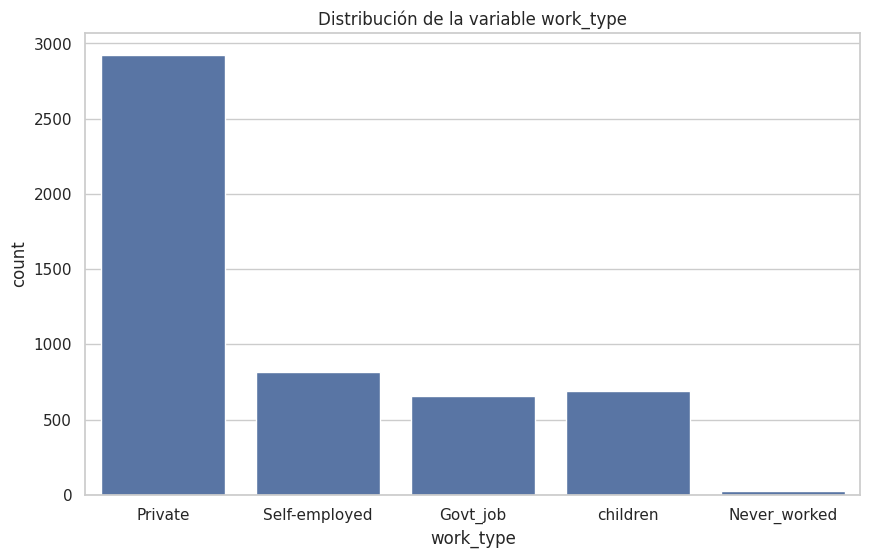

In [8]:
sns.countplot(x='work_type', data=df)
plt.title('Distribución de la variable work_type')
plt.show()

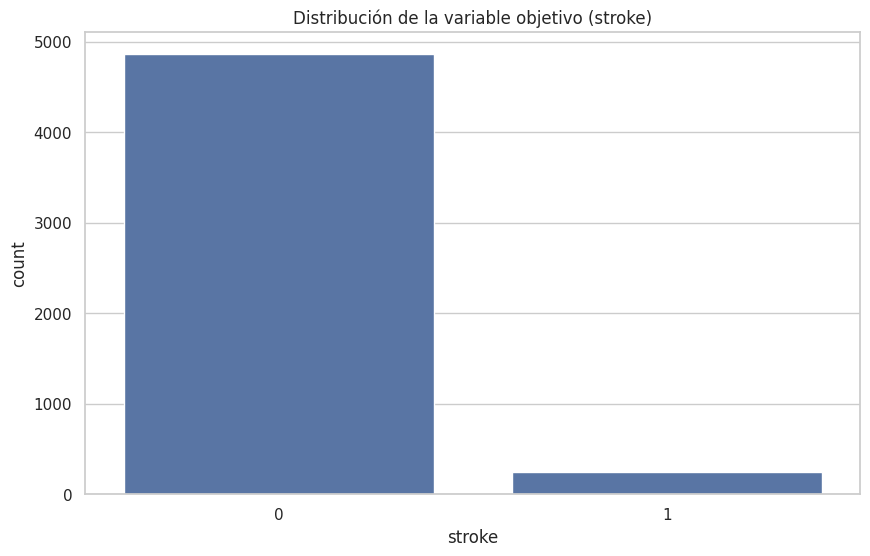

In [9]:
sns.countplot(x='stroke', data=df)
plt.title('Distribución de la variable objetivo (stroke)')
plt.show()

### Distribucion de edad, nivel de glucosa y BMI


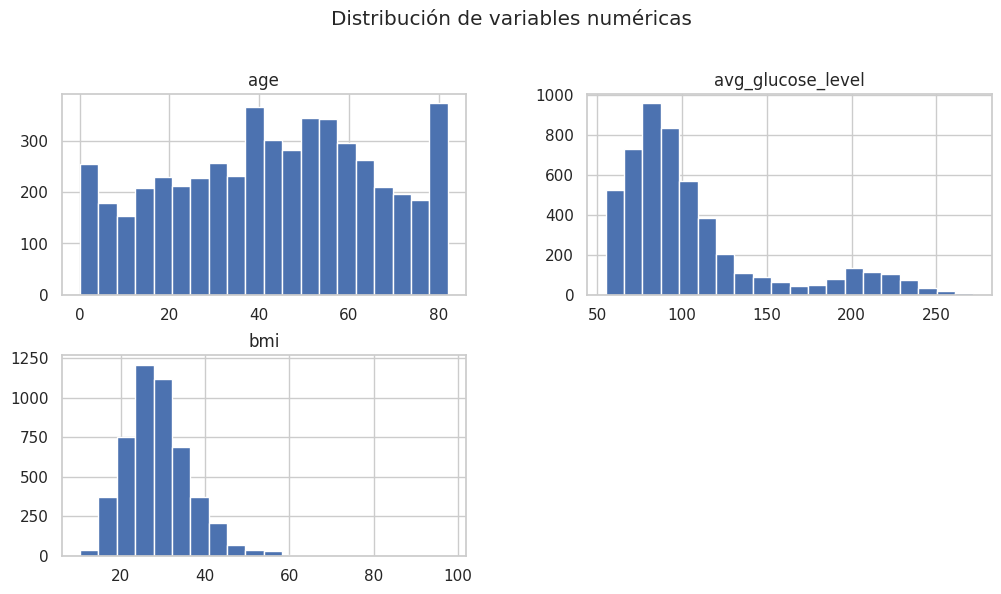

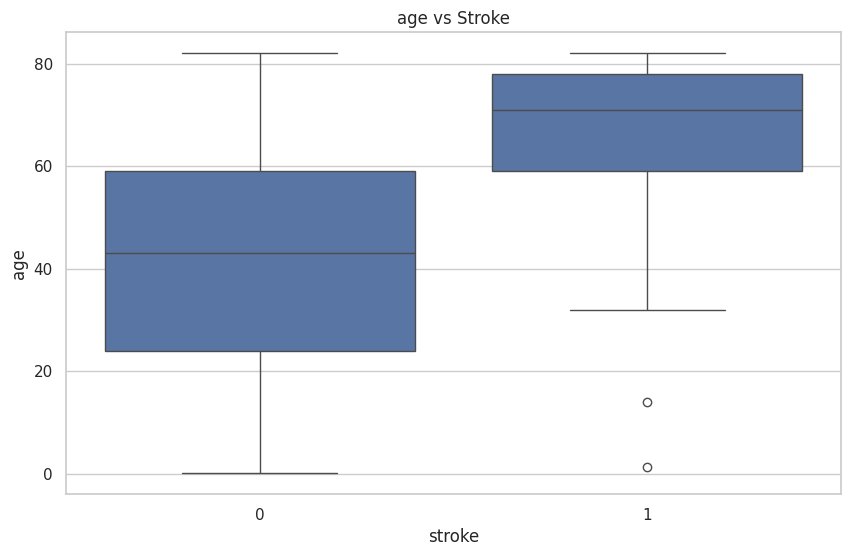

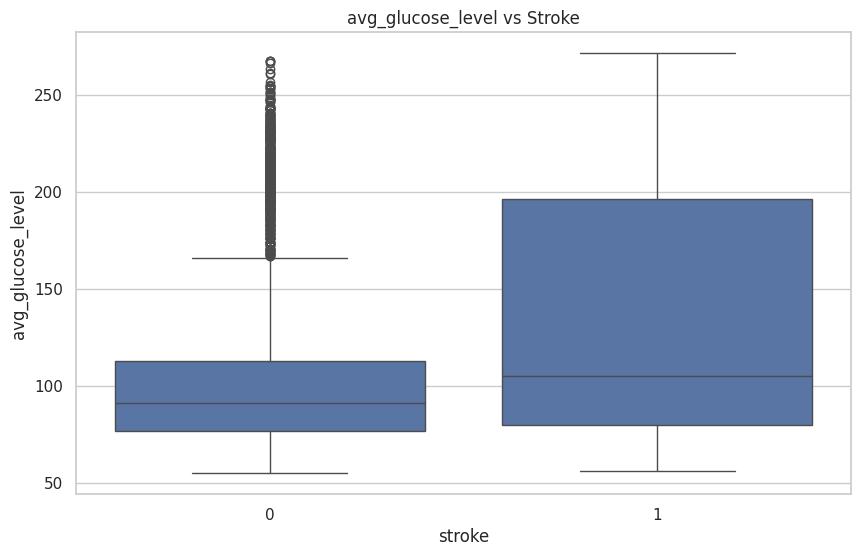

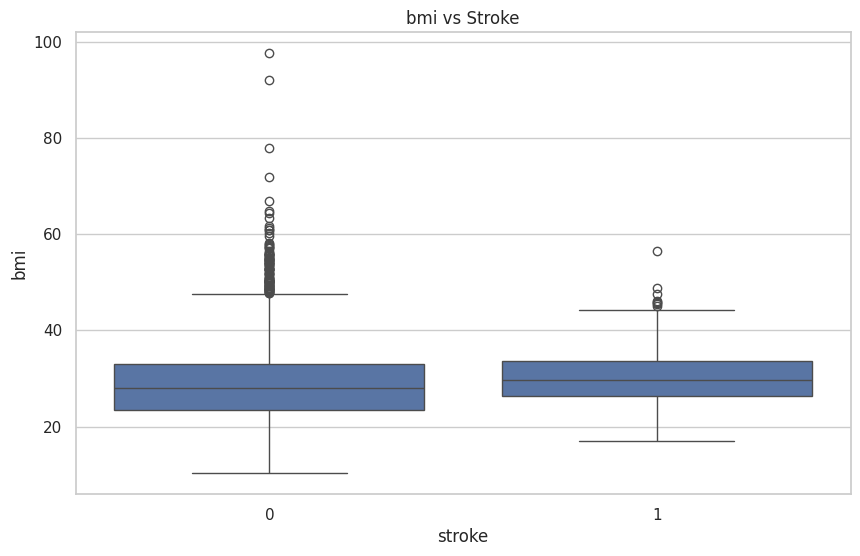

In [10]:
num_vars = ['age', 'avg_glucose_level', 'bmi']
df[num_vars].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribución de variables numéricas', y=1.02)
plt.show()

# comparanmos stroke vs variables numericas
for col in num_vars:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
    plt.show()

### Matriz de correlacion entre variables numericas

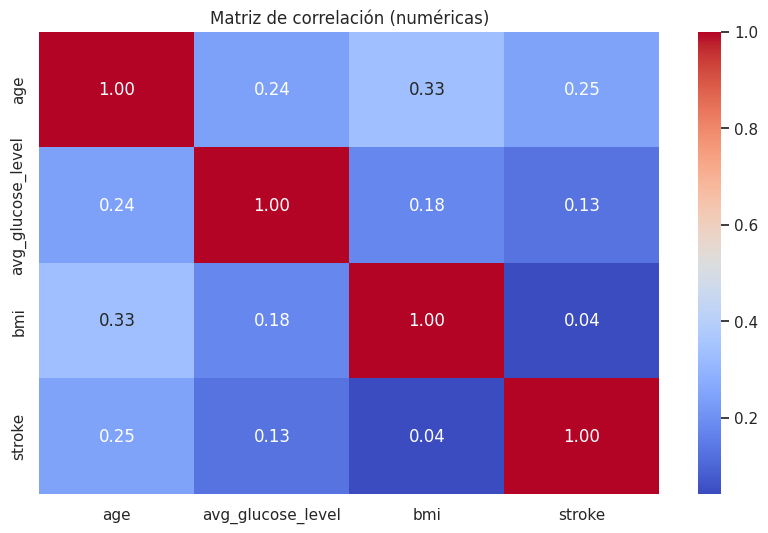

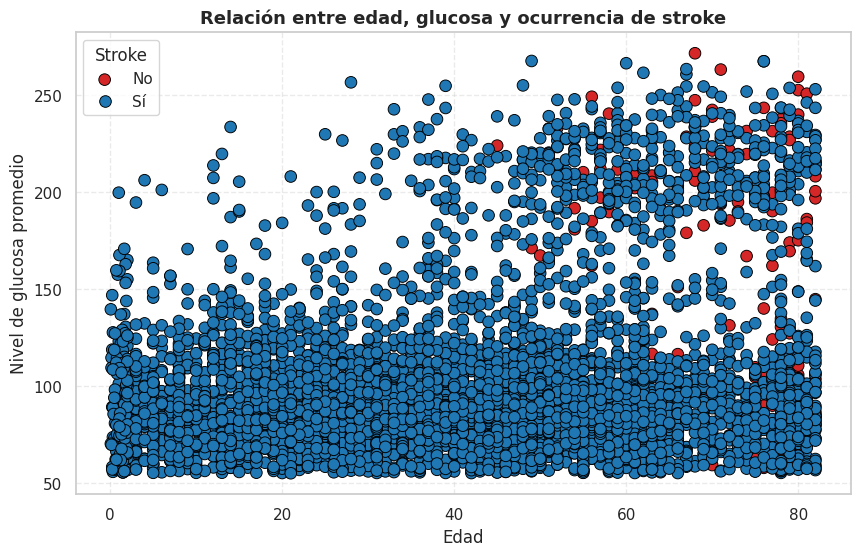

In [11]:
corr = df[num_vars + ['stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (numéricas)')
plt.show()

# Relacion entre edad y nivel de glucosa, coloreado por stroke
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    palette={0: '#1f77b4', 1: '#d62728'},  # azul fuerte para 0, rojo intenso para 1
    alpha=1,
    edgecolor='black',
    s=70  # tamaño de puntos
)
plt.title('Relación entre edad, glucosa y ocurrencia de stroke', fontsize=13, weight='bold')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend(title='Stroke', labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### Distribuciones categoricas vs Target

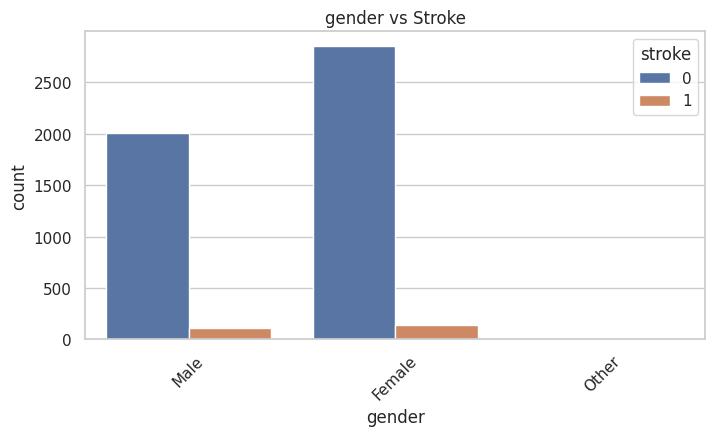

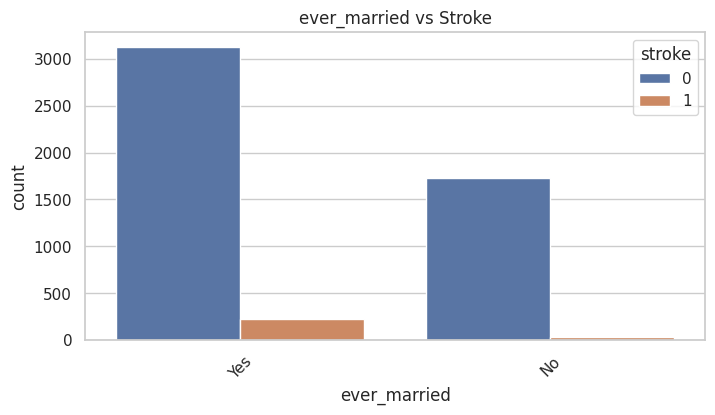

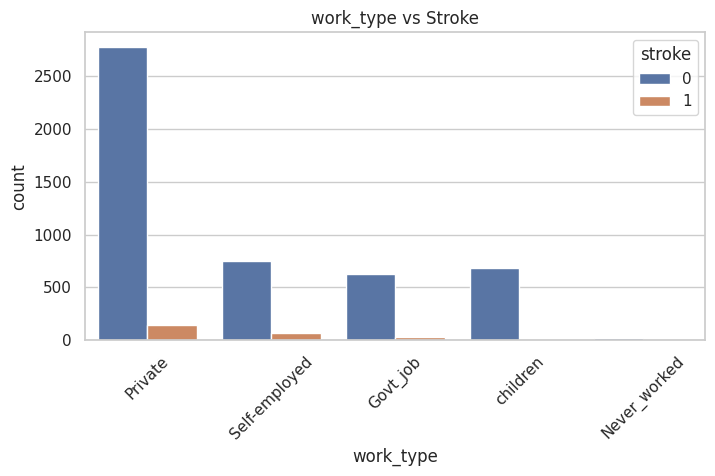

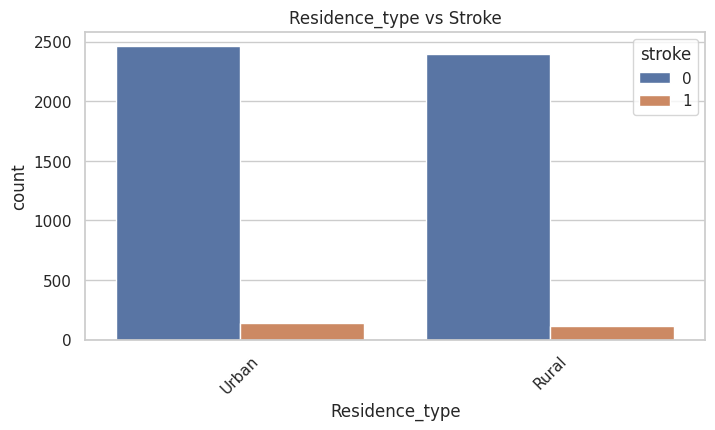

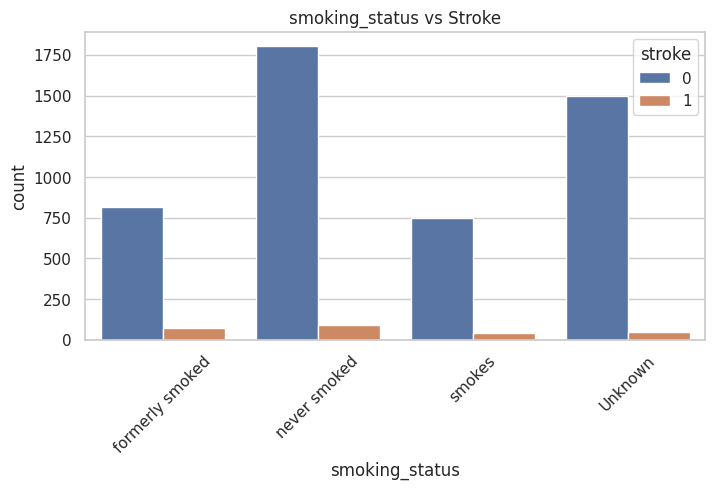

In [12]:
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.show()

# Se separa el set de entrenamiento del de testeo

Previo a las transformaciones y balanceo de los datos, se procede a crear una divison entre los sets de testeo y entrenamiento

In [13]:
# Pensemos si queremos cambiar el 0.3 a otro valor
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

# Primero: train + valid vs test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.85, stratify=y_temp)

# Transformaciones, tratamiento de Nulls y balanceo de clases

Con el objetivo de proveer datos numericos y validos al modelo de entrenamiento, utilizamos la media para rellenar los valor de `BMI` y `mos_frequent` para las variables categoricas. Luego escalamos los valores numericos y aplicamos One-Hot encoding a las variables categoricas dado que tienen una baja cardinalidad. Al final, se realiza un balanceo de clases para la variable `stroke` con el método SMOTE.

In [21]:
df['bmi'] = df['bmi'].replace('N/A', np.nan).astype(float)

num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease',
                'ever_married', 'Residence_type',
                'smoking_status', 'work_type']

# se imputan valores faltantes con median + escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# se imputan valores faltantes + One-Hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [22]:
# Se Ajustae el preprocesador solo con train

preprocessor.fit(X_train)

# Se transforman los tres conjuntos
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

In [23]:
# Se aplica el SMOTE  (Synthetic Minority Oversampling Technique)
# solo al train para evitar data leakage

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_prep, y_train)

print("\nBalance antes del SMOTE:\n", y_train.value_counts())
print("\nBalance después del SMOTE:\n", y_train_balanced.value_counts())


Balance antes del SMOTE:
 stroke
0    3401
1     175
Name: count, dtype: int64

Balance después del SMOTE:
 stroke
0    3401
1    3401
Name: count, dtype: int64


# Modelo y Pipeline (KNN)

Para este problema se utiliza un clasificador KNN (K-nearest neighbors), por las siguientes razones:

* El problema es de clasificación binaria con variables tanto numéricas como categóricas. Aplicar KNN en este caso ya que tiene un enfoque que se apoya en la proximidad entre muestras cercanas y permite capturar patrones locales.
- KNN ofrece una interpretación intuitiva, puesto que el registro de un paciente nuevo se clasifica según el grupo de pacientes al que se parecen más sus características. 


### Modelo KNN entrenado con datos desbalancedos

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train_prep, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


#### Búsqueda de hiperparámetros 

No se usa GridSearchCV porque mezclaría train y validation dentro de los folds. 

Parámetros sugeridos:

- k entre 3 y 25

- Distancia euclidiana (p=2)

- Weighting: uniform o distance

- Métrica de evaluación: F1 o Recall, porque el dataset es desbalanceado

In [ ]:
# Función para búsqueda de hiperparámetros con KNN

def hyper_search_knn(X_train, y_train, X_val, y_val, param_grid):
    best_score = -1
    best_params = None
    for k in param_grid["n_neighbors"]:
        for w in param_grid["weights"]:
            for p in param_grid["p"]:
                
                knn = KNeighborsClassifier(
                    n_neighbors=k,
                    weights=w,
                    p=p
                )
                knn.fit(X_train, y_train)

                pred_val = knn.predict(X_val)
                score = f1_score(y_val, pred_val)

                if score > best_score:
                    best_score = score
                    best_params = {"k": k, "w": w, "p": p}
    return best_score, best_params

    

In [ ]:
# Búsqueda de hiperparámetros

param_grid = {
    "n_neighbors": range(3, 26, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2]   # Manhattan y Euclidiana
}

best_score, best_params = hyper_search_knn(X_train_prep, y_train, X_val_prep, y_val, param_grid)


print("Mejores hiperparámetros encontrados:")
print(best_params)
print("Mejor F1 en validación:", best_score)



Mejores hiperparámetros encontrados:
{'k': 3, 'w': 'distance', 'p': 1}
Mejor F1 en validación: 0.11764705882352941


In [34]:
# Se entrena el mejor clasificador KNN

best_knn_unb = KNeighborsClassifier(
    n_neighbors=best_params["k"],
    weights=best_params["w"],
    p=best_params["p"]
)

best_knn_unb.fit(X_train_prep, y_train)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
pred_test_unb = best_knn_unb.predict(X_test_prep)

print("Reporte en Test con datos desbalanceados:")
print(classification_report(y_test, pred_test_unb))

cm = confusion_matrix(y_test, pred_test_unb)
print("Matriz de Confusión con datos desbalanceados:")
print(cm)

Reporte en Test:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       730
           1       0.23      0.08      0.12        37

    accuracy                           0.94       767
   macro avg       0.59      0.53      0.55       767
weighted avg       0.92      0.94      0.93       767

Matriz de Confusión:
[[720  10]
 [ 34   3]]


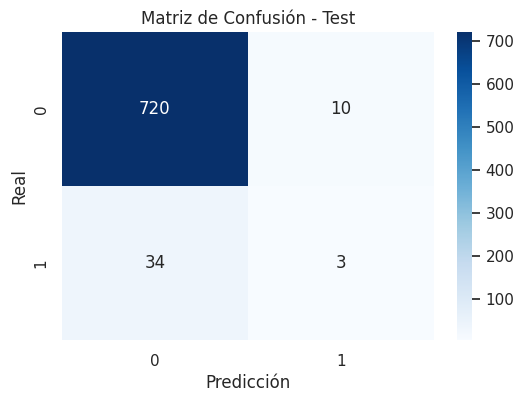

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Test con datos desbalanceados")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### Modelo KNN entrenado con datos balancedos

In [40]:
knn_bal = KNeighborsClassifier()
knn_bal.fit(X_train_prep, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [41]:
# Búsqueda de hiperparámetros

param_grid = {
    "n_neighbors": range(3, 26, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2]   # Manhattan y Euclidiana
}

best_score_bal, best_params_bal = hyper_search_knn(X_train_balanced, y_train_balanced, X_val_prep, y_val, param_grid)


print("Mejores hiperparámetros encontrados:")
print(best_params_bal)
print("Mejor F1 en validación:", best_score_bal)

Mejores hiperparámetros encontrados:
{'k': 21, 'w': 'uniform', 'p': 1}
Mejor F1 en validación: 0.2028985507246377


In [44]:
# Se entrena el mejor clasificador KNN

best_knn_bal = KNeighborsClassifier(
    n_neighbors=best_params["k"],
    weights=best_params["w"],
    p=best_params["p"]
)

best_knn_bal.fit(X_train_balanced, y_train_balanced)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [45]:
pred_test_bal = best_knn_bal.predict(X_test_prep)

print("Reporte en Test con datos balanceados:")
print(classification_report(y_test, pred_test_bal))

cm_bal = confusion_matrix(y_test, pred_test_bal)
print("Matriz de Confusión con datos balanceados:")
print(cm_bal)

Reporte en Test con datos balanceados:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       730
           1       0.11      0.19      0.14        37

    accuracy                           0.88       767
   macro avg       0.53      0.55      0.54       767
weighted avg       0.92      0.88      0.90       767

Matriz de Confusión con datos balanceados:
[[671  59]
 [ 30   7]]


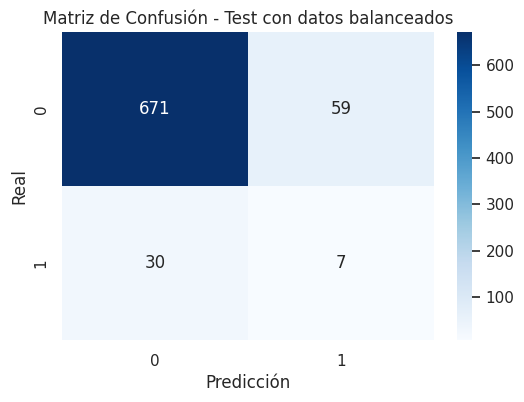

In [46]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Test con datos balanceados")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## Se analisa los resultados mediante curva ROC, Precision-Recall y matriz de confusion

**Datos Desbalanceados**

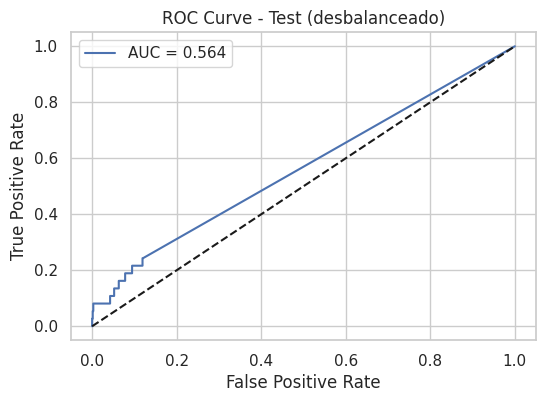

In [47]:
from sklearn.metrics import roc_curve, auc

y_test_prob = best_knn_unb.predict_proba(X_test_prep)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test (desbalanceado)")
plt.legend()
plt.show()



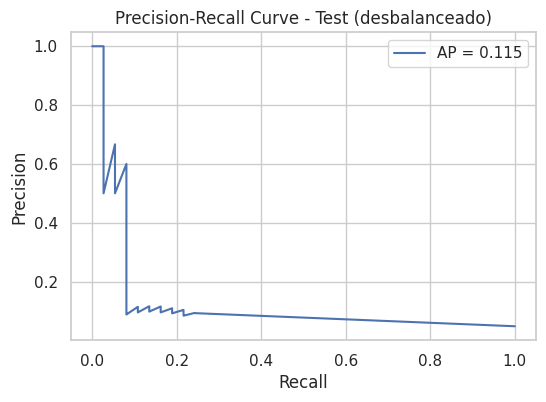

In [48]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
ap = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test (desbalanceado)")
plt.legend()
plt.show()


**Datos Desbalanceados**

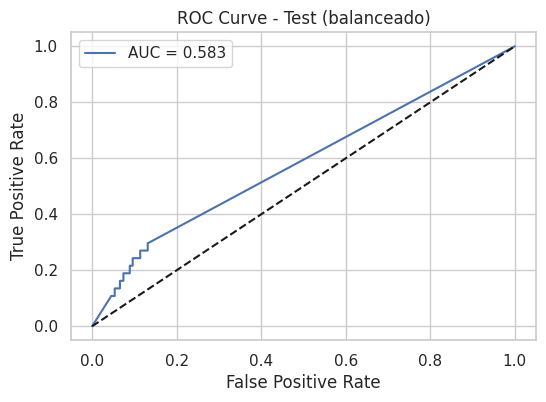

In [50]:
y_test_prob = best_knn_bal.predict_proba(X_test_prep)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test (balanceado)")
plt.legend()
plt.show()

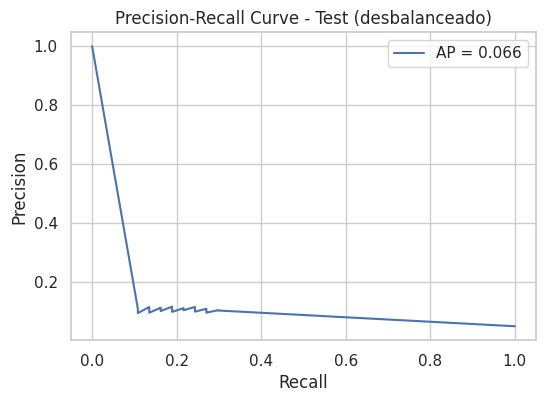

In [51]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
ap = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test (desbalanceado)")
plt.legend()
plt.show()


# Conclusion

#### Resumen de resultados:

**Set desbalanceado**

Clase 0 (mayoritaria, no stroke): precision: 0.95, recall: 0.99, f1-score: 0.97. El modelo identifica casi todos los 0 correctamente.

Clase 1 (minoritaria, stroke): precision: 0.23, recall: 0.08, f1-score: 0.12. El modelo no es capaz depredecir todos los 1 correctamente. Su capacidad de distinguir la clase minoritaria es muy mala.

**Set balanceado**

Clase 0 (mayoritaria, no stroke): precision: 0.96, recall: 0.92, f1-score: 0.94. El modelo identifica casi todos los 0 correctamente.

Clase 1 (minoritaria, stroke): precision: 0.11, recall: 0.19, f1-score: 0.14. El modelo no es capaz depredecir todos los 1 correctamente. Su capacidad de distinguir la clase minoritaria es muy mala.



Debido al amplio desbalance entre las clases del dataset, se planteó la posibilidad de usar SMOT para balancear las clases (únicamente con el set de train). Se comprararon los resultados del entrenamiento con sets balanceados y sin balancear, como se mostró anteriormente. 

De los resultados obtenidos, se pude concluir que el modelo KNN no es lo suficientemente bueno para predecir la clase minoritaria (tiene stroke). Por ser el caso actual un tema clínico, en el cual se está intentando predecir si la persona sufre o no un ACV (stroke), el hecho de que el modelo se equivoque mucho con falsos negativos (predice no-stroke pero es realmente stroke) lo hace objetivamente malo para dar soporte soporte a los profesionales médicos en el tema relacionado. 

Por otro lado, el balanceo de clases no mejora notablemente las métricas del modelo, sólo mejora mínimamente el recall. 